# Metal, Dipole, and PML

This tutorial is derived from this [script](https://github.com/facebookresearch/fmmax/blob/main/examples/metal_dipole.py).

This tutorial demonstrates how to simulate a dipole above a metal plane, surrounded by absorbing layers, using the `fmmax` library. The presence of the metal plane modifies the radiated power from the dipole, leading to angular dependence in the emission pattern. A cross section of the simulation is depicted below.

    _____________________________
    |xxx|                   |xxx|
    |xxx|                   |xxx|   x: ambient, pml
    |xxx|                   |xxx|   y: metal, pml
    |xxx|        o <-dipole |xxx|   z: metal, no pml
    |xxx|___________________|xxx|
    |yyy|zzzzzzzzzzzzzzzzzzz|yyy|

## Setting up the simulation

First, let's establish the following simulation parameters
(all lengths are in *microns* ($\mu\mathrm{m}$)):

In [1]:
from fmmax import pml

#The permittivity of the ambient.
permittivity_ambient = (1.0 + 0.0j)
#The permittivity of the metal.
permittivity_metal = (-7.632 + 0.731j)
#The distance between the dipole and the metal.
thickness_dipole_metal_gap = 1.0
#The thickness of the ambient above the dipole.
thickness_ambient = 2.0
#The thickness of the metal layer.
thickness_metal = 0.1
#The x- and y-extent of the unit cell.
pitch = 5.0
#The shape of the grid used to represent permittivities and permeabilities.
grid_shape = (400, 400)
#The spacing of grid points for calculated fields.
grid_spacing_fields = 0.01
#The wavelength of dipole emission.
wavelength = 0.63
#The approximate number of terms used in the plane wave expansion of the fields.
approximate_num_terms = 1200
#Parameters specifying the extent and strength of the perfectly matched layers.
pml_params = pml.PMLParams(num_x=50, num_y=50)

Now, we can generate the basis expansion. We also define a standard periodic boundary conditions with no extra Bloch phase.

In [2]:
from jax import numpy as jnp
from fmmax import basis

primitive_lattice_vectors = basis.LatticeVectors(
    u=pitch * basis.X, v=pitch * basis.Y
)
expansion = basis.generate_expansion(
    primitive_lattice_vectors=primitive_lattice_vectors,
    approximate_num_terms=approximate_num_terms,
    truncation=basis.Truncation.CIRCULAR,
)
in_plane_wavevector = jnp.zeros((2,))

We're now going to generate an anisotropic permittivity and permeability, which are the outcomes of applying a uniaxial Perfectly Matched Layer (PML) to the x- and y-boundaries. The Fourier Modal Method (FMM), being a semi-analytic method, is capable of perfectly matching the infinite boundaries in the z-direction. Also note that the design of the PML is based on the assumption of a unit cell, where the primitive lattice vectors are perfectly aligned with the x- and y-directions.

The following code generates these properties for both the ambient and metal mediums, using the `apply_uniaxial_pml()` function:

In [3]:
permittivities_ambient_pml, permeabilities_ambient_pml = pml.apply_uniaxial_pml(
    permittivity=jnp.full(grid_shape, permittivity_ambient),
    pml_params=pml_params,
)
permittivities_metal_pml, permeabilities_metal_pml = pml.apply_uniaxial_pml(
    permittivity=jnp.full(grid_shape, permittivity_metal),
    pml_params=pml_params,
)

## Compute Eigenmodes for each layer
FMMAX needs to solve for all the eigenmodes of each layer. Since the permittivies and permeabilities we just obtained are anisotropic, we must use the `fmm.eigensolve_general_anisotropic_media()` function to obtain the eigenmodes.

The following snippet of code uses the `functools.partial()` function from Python's standard library to create a new function eigensolve that behaves like the `fmm.eigensolve_general_anisotropic_media()` function but with some of its arguments already filled in. This is to create a new function with a specific context or configuration. Another advantage of using `functools.partial()` over lambda expressions or anonymous functions is that it provides better introspection capabilities, which can be particularly useful for debugging and tracing purposes within the context of JAX.

In [4]:
from fmmax import fmm
import functools

eigensolve = functools.partial(
    fmm.eigensolve_general_anisotropic_media,
    wavelength=jnp.asarray(wavelength),
    in_plane_wavevector=in_plane_wavevector,
    primitive_lattice_vectors=primitive_lattice_vectors,
    expansion=expansion,
    formulation=fmm.Formulation.FFT,
    vector_field_source=None,  # Automatically choose the vector field source.
)

Now that we have the information pre-filled in, we can start using this newly defined function `eigensolve()` by passing in the permittivity and permeability information. We will keep track of the solve results separately for the eigenmodes above (`solve_result_ambient`) and below (`solve_result_method`) the source.

In [5]:
solve_result_ambient = eigensolve(
    permittivity_xx=permittivities_ambient_pml[0],
    permittivity_xy=permittivities_ambient_pml[1],
    permittivity_yx=permittivities_ambient_pml[2],
    permittivity_yy=permittivities_ambient_pml[3],
    permittivity_zz=permittivities_ambient_pml[4],
    permeability_xx=permeabilities_ambient_pml[0],
    permeability_xy=permeabilities_ambient_pml[1],
    permeability_yx=permeabilities_ambient_pml[2],
    permeability_yy=permeabilities_ambient_pml[3],
    permeability_zz=permeabilities_ambient_pml[4],
)
solve_result_metal = eigensolve(
    permittivity_xx=permittivities_metal_pml[0],
    permittivity_xy=permittivities_metal_pml[1],
    permittivity_yx=permittivities_metal_pml[2],
    permittivity_yy=permittivities_metal_pml[3],
    permittivity_zz=permittivities_metal_pml[4],
    permeability_xx=permeabilities_metal_pml[0],
    permeability_xy=permeabilities_metal_pml[1],
    permeability_yx=permeabilities_metal_pml[2],
    permeability_yy=permeabilities_metal_pml[3],
    permeability_zz=permeabilities_metal_pml[4],
)

## Calculate the scattering matrices for each substack

We are now prepared to compute the scattering matrices (s-matrices). These matrices define the relationship between the forward- and backward-propagating eigenmodes within each layer. The FMMAX library offers a variety of routines for this purpose, each with varying degrees of abstraction.

In this specific context, our objective is to independently compute the s-matrices for two distinct portions (substacks): the upper (ambient) and the lower (from the dipole to the metal gap, and the metal itself). Instead of merging the layers at this point, we strategically place our dipole source between these two portions. This method allows us to associate the dipole source with the corresponding s-matrices of each portion.

The following code illustrates this procedure:

In [6]:
from fmmax import scattering

# Compute interior scattering matrices to enable field calculations.
s_matrices_interior_before_source = scattering.stack_s_matrices_interior(
    layer_solve_results=[solve_result_ambient],
    layer_thicknesses=[jnp.asarray(thickness_ambient)],
)
s_matrices_interior_after_source = scattering.stack_s_matrices_interior(
    layer_solve_results=[solve_result_ambient, solve_result_metal],
    layer_thicknesses=[
        jnp.asarray(thickness_dipole_metal_gap),
        jnp.asarray(thickness_metal),
    ],
)

## Create a dipole source

We are now ready to create our dipole source, which is periodically located at the center of our unit cell. First, we use the `sources.dirac_delta_source()` to expand the dipole into superpositions of planewaves. Then, we want the source to propagate in both directions, upwards and downwards as an 'embedded source'.

In [7]:
from fmmax import sources

# Generate the Fourier representation of a point dipole.
dipole = sources.dirac_delta_source(
    location=jnp.asarray([[pitch / 2, pitch / 2]]),
    in_plane_wavevector=in_plane_wavevector,
    primitive_lattice_vectors=primitive_lattice_vectors,
    expansion=expansion,
)

Before we can calculate the amplitudes of the dipole source, we must obtain the s-matrices relating fields at the two ends of each substack. We obtained this information earlier using the function `scattering.stack_s_matrices_interior()`. This function returns a `Tuple` of s-matrix substacks where each substack is a `Tuple` of individual s-matrix corresponding to the different layers.

In [8]:
s_matrix_before_source = s_matrices_interior_before_source[0][0]
s_matrix_after_source = s_matrices_interior_after_source[-1][0]

We have now all the information needed to propagate the dipole source into the top and bottom substacks. The `sources.amplitudes_for_source()` function will properly convert the dipole electric current sources to the corresponding Fourier field amplitudes and propagate them along both directions (top and bottom in this context).

In [9]:
# Compute backward eigenmode amplitudes at the end of the layer before the
# source, and the forward amplitudes the start of the layer after the source.
(
    _,
    _,
    bwd_amplitude_before_end,
    fwd_amplitude_after_start,
    _,
    _,
) = sources.amplitudes_for_source(
    jx=jnp.zeros_like(dipole),
    jy=dipole, # Only excite the y polarization.
    jz=jnp.zeros_like(dipole),
    s_matrix_before_source=s_matrix_before_source,
    s_matrix_after_source=s_matrix_after_source,
)

With the forward and backward propagating Fourier field amplitudes calculated, we can use these amplitudes to excite the eigenmodes we previously calculated given the scattering matrices before (`s_matrix_before_source`) and after ( `s_matrix_after_source`) the source. The function we use here is called `fields.stack_amplitudes_interior_with_source()`, which returns the forward- and backward-propagating wave amplitude for each layer.

In [10]:
from fmmax import fields

# Solve for the eigenmode amplitudes in every layer of the stack.
amplitudes_interior = fields.stack_amplitudes_interior_with_source(
    s_matrices_interior_before_source=s_matrices_interior_before_source,
    s_matrices_interior_after_source=s_matrices_interior_after_source,
    backward_amplitude_before_end=bwd_amplitude_before_end,
    forward_amplitude_after_start=fwd_amplitude_after_start,
)

# Visualization

Thus far, we have obtained the s-matrices and the propagating wave amplitudes for each layer. We can use a function called `fields.stack_fields_3d_on_coordinates()` to convert that into a cartesian 3d vector field to visualize. We can take a 2d cross section by specifying the x coordinates to span across the entire period, while keeping the y coordinates constant.

In [11]:
# Coordinates where fields are to be evaluated.
x = jnp.linspace(0, pitch, grid_shape[0])
y = jnp.ones_like(x) * pitch / 2
(ex, ey, ez), (hx, hy, hz), (x, y, z) = fields.stack_fields_3d_on_coordinates(
    amplitudes_interior=amplitudes_interior,
    layer_solve_results=[
        solve_result_ambient,
        solve_result_ambient,
        solve_result_metal,
    ],
    layer_thicknesses=[
        jnp.asarray(thickness_ambient),
        jnp.asarray(thickness_dipole_metal_gap),
        jnp.asarray(thickness_metal),
    ],
    layer_znum=[
        int(thickness_ambient / grid_spacing_fields),
        int(thickness_dipole_metal_gap / grid_spacing_fields),
        int(thickness_metal / grid_spacing_fields),
    ],
    x=x,
    y=y,
)

Let's visualize the amplitude of the electric field now!

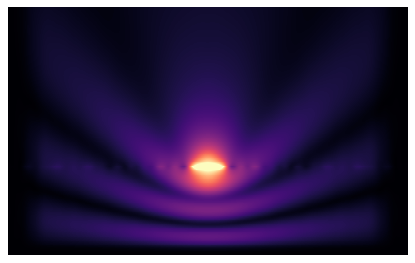

In [12]:
import matplotlib.pyplot as plt

field_3d = jnp.sqrt(jnp.abs(ex) ** 2 + jnp.abs(ey) ** 2 + jnp.abs(ez) ** 2)
field_plot = field_3d[:, :, 1]

xplot, zplot = jnp.meshgrid(x, z, indexing="ij")

plt.figure(figsize=(float(jnp.amax(xplot)), float(jnp.amax(zplot))), dpi=80)
ax = plt.subplot(111)
im = ax.pcolormesh(xplot, zplot, field_plot, shading="nearest", cmap="magma")

# Clip the color scale to the 99.8th percentile of the field.
clip_percentile = 99.8
clipval = float(jnp.percentile(field_plot, clip_percentile))
im.set_clim((0, clipval))

ax.axis("equal")
ax.axis("off")
ax.set_ylim(ax.get_ylim()[::-1])

plt.subplots_adjust(left=0, bottom=0, right=1, top=1)
plt.show()

As you can see, the plot above shows a clear view of the PML on the sides, as it the attenuates the dipole amplitudes with minimal back reflections. The metal plane is also visible beneath the dipole. It's worth noting that the dipole is has a finite width, and thus utilizing more Fourier terms can improve the resolution of an actual "delta function" point source (as demonstrated in the [previous tutorial](https://facebookresearch.github.io/fmmax/Tutorials/dipoles)).